In [3]:
import numpy as np
import ltspice
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from mpl_toolkits.mplot3d import axes3d

In [4]:
font = {'family' : 'Times New Roman',
        'weight' : 'regular',
        'size'   : 12}

matplotlib.rc('font', **font)

## Generate XOR Data

In [5]:
x = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
y = np.array([-1, 1, 1, -1])

a = b = np.arange(-1.5, 1.6, 0.1)  # End is 1.6 so that range will stop at 
                                   # 1.6 - step = 1.5
A, B = np.meshgrid(a, b)

## Load LTSpice Simulation Data

In [6]:
# Parse simulation data.
filepath = 'xor.raw'
l = ltspice.Ltspice(filepath)
l.parse()

# Extract simulation data and split into simulation cases.
y_sim = l.getData('V(y)')
y_sim = np.array(np.split(y_sim, 31))  # From -1.5 to 1.5 with a 0.1 step, 
                                       # therefore 31 cases.

## Generate TF Model with Known Weights

In [5]:
def accuracy(y_true, y_pred):
  return K.abs(y_true - y_pred) < 0.1

model = Sequential()

model.add(Dense(2, activation='tanh', input_shape=(2,)))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=SGD(lr=0.1),
              loss='mse',
              metrics=[accuracy])

model.layers[0].set_weights(
    [np.array([[-1.4473087, -1.6303953], [-1.4470474, -1.6299497]]), 
     np.array([-1.2659273, 1.474662 ])])
model.layers[1].set_weights(
    [np.array([[-2.3368418], [ 2.3172097]]), 
     np.array([-2.0349612])])

y_tf = model.predict(np.array(list(zip(A.flatten(), B.flatten()))))

# Reshape the model output.
y_tf = y_tf.flatten()
y_tf = np.split(y_tf, 31)
y_tf = np.array(y_tf)

## Plot the Model Outputs

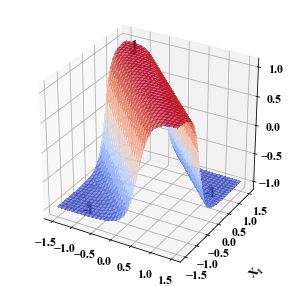

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))

ax = plt.subplot(projection='3d')

surf = ax.plot_surface(A, B, y_tf, cmap='coolwarm',
                       linewidth=0, antialiased=False, alpha=0.6)

# Add true data points.
ax.scatter(x[:, 0], x[:, 1], y, c='k')
for j, txt in enumerate(y):
  ax.text(x[j, 0], x[j, 1], y[j] * 1.1, txt, size=14, ha='center', va='center')

ax.set_xlabel(r'$\mathregular{X_0}$', labelpad=20)
ax.set_ylabel(r'$\mathregular{X_1}$', labelpad=20)
ax.set_zlabel(r'$\mathregular{Y}$', labelpad=20)

fig.savefig('../img/tf_model.svg')

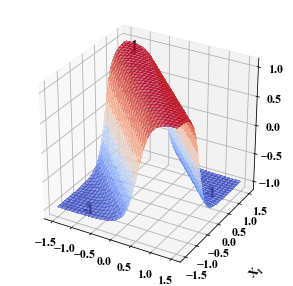

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))

ax = plt.subplot(projection='3d')

surf = ax.plot_surface(A, B, y_sim, cmap='coolwarm',
                       linewidth=0, antialiased=False, alpha=0.6)

# Add true data points.
ax.scatter(x[:, 0], x[:, 1], y, c='k')
for j, txt in enumerate(y):
  ax.text(x[j, 0], x[j, 1], y[j] * 1.1, txt, size=14, ha='center', va='center')

ax.set_xlabel(r'$\mathregular{X_0}$', labelpad=20)
ax.set_ylabel(r'$\mathregular{X_1}$', labelpad=20)
ax.set_zlabel(r'$\mathregular{Y}$', labelpad=20)

fig.savefig('../img/ltspice_model.svg')

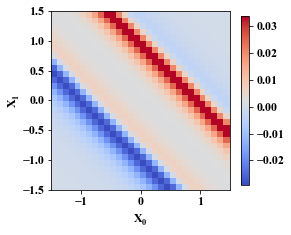

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))

im = ax.pcolormesh(A, B, y_tf - y_sim, cmap='coolwarm')
ax.set_xlabel(r'$\mathregular{X_0}$', labelpad=5)
ax.set_ylabel(r'$\mathregular{X_1}$', labelpad=0)
ax.set_aspect('equal')
fig.colorbar(im, ax=ax, shrink=0.775)

fig.savefig('../img/model_diff.svg')

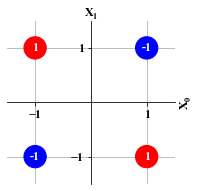

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.grid(alpha=1, zorder=-1)
ax.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', s=500, zorder=10)
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(-1.5, 1.5)
plt.yticks([-1, 1])
plt.xticks([-1, 1])
ax.set_ylabel(r'$\mathregular{X_0}$')
ax.set_xlabel(r'$\mathregular{X_1}$')
ax.xaxis.set_label_position('top')
ax.yaxis.set_label_position('right')

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i, txt in enumerate(y):
  ax.annotate(txt, (x[i, 0], x[i, 1]), ha='center', va='center', color='w', zorder=11)

fig.savefig('../img/xor_plane.svg')